# Extrem Value Analysis

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyextremes import EVA, __version__


In [44]:
data = pd.read_excel("s&p 500.xlsx", index_col=0,parse_dates=True)
data.shape
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [78]:
data['Close'].index

DatetimeIndex(['2021-03-19', '2021-03-18', '2021-03-17', '2021-03-16',
               '2021-03-15', '2021-03-12', '2021-03-11', '2021-03-10',
               '2021-03-09', '2021-03-08',
               ...
               '1970-04-06', '1970-04-03', '1970-04-02', '1970-04-01',
               '1970-03-31', '1970-03-30', '1970-03-26', '1970-03-25',
               '1970-03-24', '1970-03-23'],
              dtype='datetime64[ns]', name='Date', length=12864, freq=None)

In [92]:
closed_price = [p.replace(',','') for p in data['Close']]
closed_price = np.array(closed_price)
closed_price = closed_price.astype(float)
daily_return = np.diff(closed_price) / closed_price[:-1]
log_daily_return = np.log(1 + daily_return)

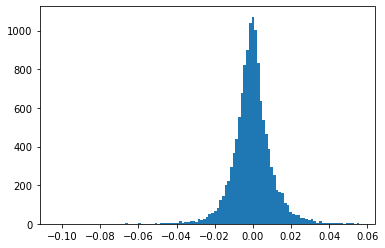

In [106]:
plt.hist(daily_return[daily_return < 0.06 ], bins = int(np.sqrt(len(daily_return))))
plt.show()


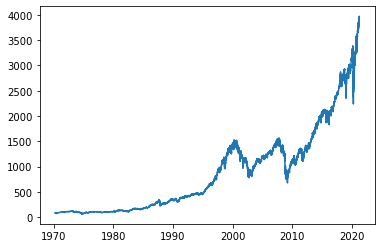

In [90]:
plt.plot(data['Close'][:-1].index,daily_return)
plt.plot(data['Close'][:-1].index,closed_price[:-1])


In [113]:
model = EVA(data=pd.Series(data = log_daily_return, index = data['Close'][:-1].index).sort_index(ascending=True))
model.get_extremes(
    method="BM",
    extremes_type="high",
    block_size="365.2425D",
    errors="raise",
)
model.fit_model()
model

                           Univariate Extreme Value Analysis                            
                                      Source Data                                       
----------------------------------------------------------------------------------------
Data label:                          None      Size:                              12,863
Start:                         March 1970      End:                           March 2021
                                     Extreme Values                                     
----------------------------------------------------------------------------------------
Count:                                 51      Extraction method:                     BM
Type:                                high      Block size:             365 days 05:49:12
                                         Model                                          
----------------------------------------------------------------------------------------
Model:               

(<Figure size 768x480 with 1 Axes>,
 <AxesSubplot:xlabel='Date', ylabel='extreme values'>)

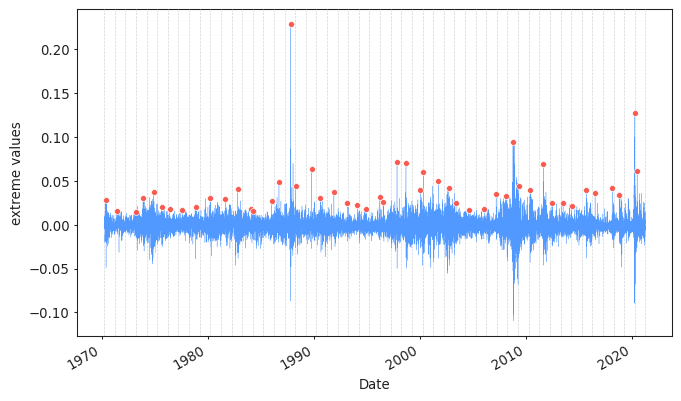

In [112]:
model.plot_extremes()

(<Figure size 768x768 with 4 Axes>,
 (<AxesSubplot:title={'center':'Return value plot'}, xlabel='Return period', ylabel='extreme values'>,
  <AxesSubplot:title={'center':'Probability density plot'}, ylabel='Probability density'>,
  <AxesSubplot:title={'center':'Q-Q plot'}, xlabel='Theoretical', ylabel='Observed'>,
  <AxesSubplot:title={'center':'P-P plot'}, xlabel='Theoretical', ylabel='Observed'>))

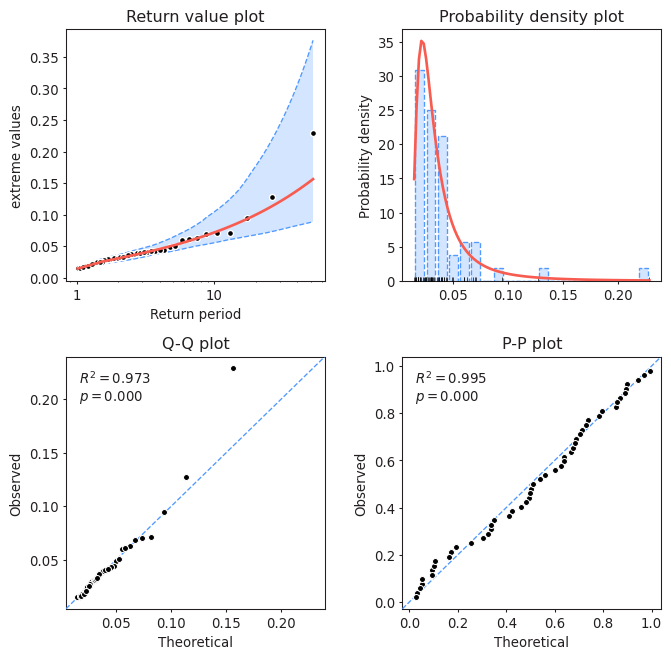

In [114]:
model.plot_diagnostic(alpha=0.95)

(<Figure size 768x480 with 1 Axes>,
 <AxesSubplot:xlabel='Return period', ylabel='extreme values'>)

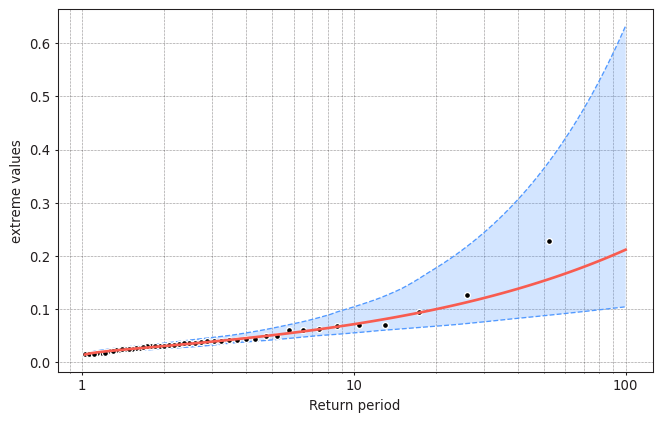

In [115]:
model.plot_return_values(
    return_period=np.logspace(0.01, 2, 100),
    return_period_size="365.2425D",
    alpha=0.95,
)